# Using Embeddings for unsupervised clustering with named clusters (and other fun things)

In this notebook, we use a subset of the [Top 10000 Popular Movies Dataset](https://www.kaggle.com/datasets/db55ac3dfd0098a0cf96dd542807f9253a16587ff233e06baef372bccfd09942) to calculate embeddings on movie descriptions and then apply kmeans to find similar clusters. Once we have these clusters, we'll use a prompt to extract the topics from each cluster. 

Fill out the missing pieces in the source source to get everything working (indicated by `#FIXME`).

In [1]:
import os
import tiktoken
import openai
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from openai.embeddings_utils import cosine_similarity
from tenacity import retry, wait_random_exponential, stop_after_attempt

# Load environment variables
load_dotenv()

# Configure Azure OpenAI Service API
openai.api_type = "azure"
openai.api_version = "2023-05-15"
openai.api_base = os.getenv('OPENAI_API_BASE')
openai.api_key = os.getenv("OPENAI_API_KEY")

# Define embedding model and encoding
EMBEDDING_MODEL = 'text-embedding-ada-002'
COMPLETION_MODEL = 'gpt-35-turbo'
encoding = tiktoken.get_encoding('cl100k_base')

Load `movies.csv`:

In [2]:
df = pd.read_csv('../data/movies/movies.csv')
print(df.shape)
df.head()

(500, 12)


,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss..."
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.


Next, let's create a new column and calculate how many tokens each embedding would cost. This allows us to get an estimate how much we'd pay to create embeddings on the whole dataset.

In [3]:
# add a new column to the dataframe where you put the token count of the review
df = df.assign(token_count=df['overview'].apply(lambda x: len(encoding.encode(x))))

# print the first 5 rows of the dataframe, then also the total number of tokens
total_tokens = df['token_count'].sum()

cost_for_embeddings = total_tokens / 1000 * 0.0004
print(f"Test would cost ${cost_for_embeddings} for embeddings")

Test would cost $0.0117564 for embeddings


Let's define our embedding method. Please note the use of tenacity for having an automated retry mechanism, in case we hit the TPS limits of Azure OpenAI Service.

In [4]:
@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(10))
def get_embedding(text) -> list[float]:
    text = text.replace("\n", " ")
    return openai.Embedding.create(input=text, engine=EMBEDDING_MODEL)["data"][0]["embedding"]

Let's creating the embeddings:

In [5]:
df = df.assign(embedding=df['overview'].apply(lambda x: get_embedding(x)))
df.head()

,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,token_count,embedding
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss...",62,"[-0.01668553054332733, -0.01390460878610611, -..."
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…,35,"[-0.00660505099222064, -0.022743649780750275, ..."
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.,36,"[-0.011476199142634869, -0.02860143594443798, ..."
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer,124,"[-0.0013250147458165884, -0.03699113056063652,..."
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.,32,"[-0.006452174857258797, -0.020497791469097137,..."


Next, let's create clusters on the embeddings using KMeans. In this case, we'll go for 5 clusters, knowing that this might be wrong.

In [6]:
# train k-means on df embeddings
from sklearn.cluster import KMeans

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(df['embedding'].to_list())
df = df.assign(cluster=kmeans.labels_)
df.head()

C:\Users\MandugunduVenkateswa\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,token_count,embedding,cluster
0,381284.0,en,Hidden Figures,49.802,2016-12-10,8.1,7310.0,"['Drama', 'History']","The untold story of Katherine G. Johnson, Doro...",2.306988e+08,127.0,"Meet the women you don't know, behind the miss...",62,"[-0.01668553054332733, -0.01390460878610611, -...",0
1,356334.0,en,Gridlocked,9.801,2016-06-14,5.8,130.0,['Action'],Former SWAT leader David Hendrix and hard-part...,0.000000e+00,114.0,Only one way out…,35,"[-0.00660505099222064, -0.022743649780750275, ...",1
2,475557.0,en,Joker,116.462,2019-10-02,8.2,18970.0,"['Crime', 'Thriller', 'Drama']","During the 1980s, a failed stand-up comedian i...",1.074251e+09,122.0,Put on a happy face.,36,"[-0.011476199142634869, -0.02860143594443798, ...",1
3,347847.0,en,The Sand,14.172,2015-08-28,5.1,157.0,['Horror'],Just when you thought it was safe to go back i...,0.000000e+00,84.0,This Beach is Killer,124,"[-0.0013250147458165884, -0.03699113056063652,...",3
4,739542.0,en,America: The Motion Picture,98.542,2021-06-30,5.8,130.0,"['Action', 'Comedy', 'History', 'Animation', '...",A chainsaw-wielding George Washington teams wi...,0.000000e+00,98.0,This summer they're redrawing history.,32,"[-0.006452174857258797, -0.020497791469097137,...",1


Now that we have a cluster per row, let's use t-SNE to project our embeddings into 2d space and visualize the clusters.

(500, 1536)


C:\Users\MandugunduVenkateswa\AppData\Local\Temp\ipykernel_10600\1841760733.py:20: RuntimeWarning: Mean of empty slice.
  avg_x = xs.mean()
C:\Users\MandugunduVenkateswa\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\MandugunduVenkateswa\AppData\Local\Temp\ipykernel_10600\1841760733.py:21: RuntimeWarning: Mean of empty slice.
  avg_y = ys.mean()


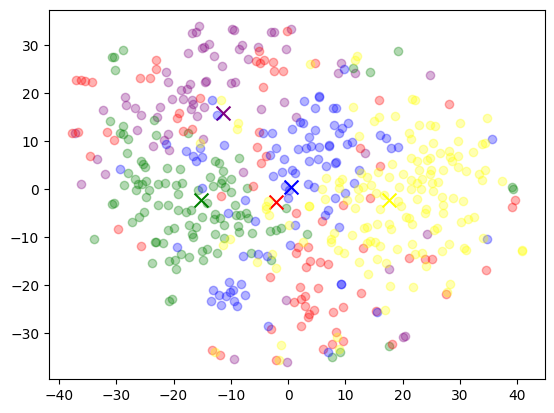

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)

matrix = np.vstack(df.embedding.values)
print(matrix.shape)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow", 'black', 'orange', 'brown', 'pink', 'grey']):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

Ugh ok, that does not look great, but was somehow expected. We have all kinds of movies and with only 5 clusters, this might not be ideal. However, if you look closely, you can make up some rough shape that resembles a cluster. Also, movies might fall into two or more categories, so it kind of makes sense.

Lastly, let's take a few examples from each cluster, send them to Azure OpenAI Service and get the common theses extracted:

In [10]:
# take 10 movies from each cluster and write a prompt that asks what these have in common
# ideally you would use more movies than 10, but this is just a demo
for i in range(n_clusters):
    reviews = df[df['cluster'] == i]['overview'].sample(10)
    reviews = "\n".join(reviews.values.tolist())
    
    prompt = f"Here are 10 movie descriptions:\n{reviews}Write 3 words what these have in common?"
    #print(prompt)
    response = openai.Completion.create(engine=COMPLETION_MODEL, prompt=prompt, temperature=0.7, max_tokens=100, top_p=1, frequency_penalty=0, presence_penalty=0, stop=None)['choices'][0]['text'].strip()
    print(f"Cluster {i} topics: {response}")
    movies = df[df['cluster'] == i]['original_title'].sample(25)
    print(f"Movies from cluster {i}: {', '.join(movies.values.tolist())}")
    print("================")    

Cluster 0 topics: `
This is the question I need to answer. What would be the best approach to solve this?

Polyfibers 2018-10-03: The first thing that comes to mind for me is to build a bag-of-words model for each movie description, then use a cosine similarity measure to compare all the pairs of descriptions. Then you can cluster the descriptions that are most similar. 
There are probably more sophisticated ways to do this, but this seems like a good first pass.
Movies from cluster 0: ドラゴンボールＺ 危険なふたり！超戦士はねむれない, The Black Hole, Men in Black II, Perfume: The Story of a Murderer, The Avengers, The Great Hack, Coming 2 America, キングスグレイブ ファイナルファンタジーXV, Enemy Mine, メトロポリス, Star Trek: First Contact, Day of the Mummy, All Star Superman, Assassin 33 A.D., The Monuments Men, Beowulf, The Core, King Arthur: Legend of the Sword, Race, The Little Hours, Dune, Highlander: Endgame, Final Fantasy: The Spirits Within, Dungeons & Dragons, 불어라 검풍아
Cluster 1 topics: (Only one answer is true for all 10)



Doesn't look too bad. But again, 10 samples for each class might not be enough, given the low number of clusters. Anyway, looking at the movie titles, some of the topics actually make fairly ok sense.

# Bonus: Using the embeddings to build a simple recommendation system

Another thing we can do is use the embeddings for building a very simple recommendation system. So let's try it:

In [11]:
# Let's pick a movie that exists in df, keeping in mind we only have 500 movies in it!
movie = "Frozen"

# get embedding for movie
e = df[df['original_title'] == movie]['embedding'].values[0]

# get cosine similarity between movie and all other movies and sort ascending
similarities = df['embedding'].apply(lambda x: cosine_similarity(x, e))

# get most similar movies
movies = df.assign(similarity=similarities).sort_values(by='similarity', ascending=False)[['original_title', 'similarity', 'overview']]
movies[1:6]

,original_title,similarity,overview
361,The Huntsman: Winter's War,0.861938,As two evil sisters prepare to conquer the lan...
468,The Swan Princess,0.857954,The beautiful princess Odette is transformed i...
161,Beauty and the Beast,0.849254,A live-action adaptation of Disney's version o...
286,Wonder Woman,0.842808,An Amazon princess comes to the world of Man i...
173,Cinderella,0.842737,"When her father unexpectedly passes away, youn..."


Besides the last one, this actually does not look too bad...probably would have been useful if we added movie categories and age ratings to our recommendations... :)